In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768, 14548, 14590]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

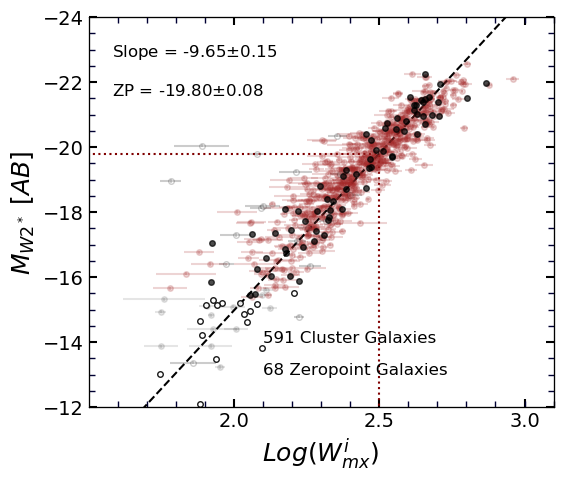

In [4]:
band = 'w2'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True)

In [5]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[ -9.64898538   0.15064099 -19.79845425   0.07942002]


In [6]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -9.648985382071904 13.422685784193128 33.136469222486525 Pegasus
NEST_200037 -9.648985382071904 14.748565869833994 34.58853816511023 NGC70
NEST_200017 -9.648985382071904 15.37346873839961 35.09256410258257 Abell 539
NEST_200005 -9.648985382071904 14.198850648874346 33.98731218577798 NGC410
NEST_200006 -9.648985382071904 14.281944691573521 34.06236134882555 NGC507
NEST_100014 -9.648985382071904 12.976223938923683 32.779313003302086 Antlia
NEST_200003 -9.648985382071904 14.10175987869742 33.89836514011742 Abell 262
NEST_100001 -9.648985382071904 15.100503017032871 34.895853444597336 Coma
NEST_100003 -9.648985382071904 12.81601851151323 32.61036629534313 Centaurus
NEST_100002 -9.648985382071904 11.017967371200875 30.94085651291726 Virgo
NEST_100005 -9.648985382071904 15.067572025350351 34.864072301523045 Abell 1367
NEST_200045 -9.648985382071904 14.604296274811446 34.3999870568098 NGC80
NEST_100007 -9.648985382071904 16.273687670089902 36.06416201026677 Abell 2151 (Hercules)
N

In [7]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (25) -8.53 0.54 11.14 0.11 11.02 0.11 0.96


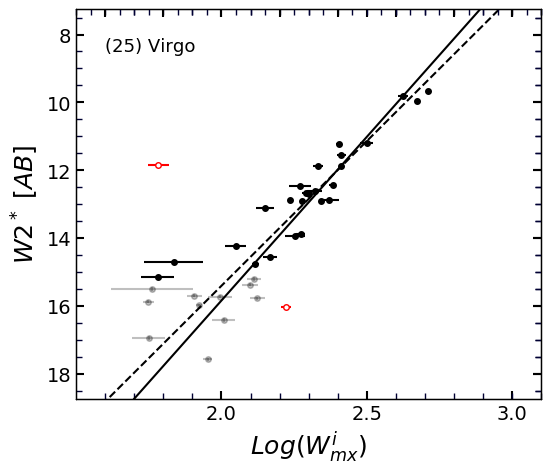

In [8]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (25) -8.53 0.54 11.14 0.11 11.02 0.11 0.96
Ursa Major (37) -10.16 0.52 11.32 0.09 11.36 0.08 0.62
Fornax (17) -8.96 0.67 11.44 0.15 11.42 0.16 0.83
Centaurus (23) -10.05 1.38 12.81 0.15 12.82 0.14 0.74
Antlia (17) -10.16 1.14 12.98 0.13 12.98 0.12 0.66
Pegasus (25) -10.17 1.03 13.34 0.21 13.42 0.11 0.64
Hydra (45) -8.44 0.59 13.86 0.09 13.89 0.11 0.92
Abell 262 (55) -8.84 0.72 14.10 0.13 14.10 0.14 1.01
NGC410 (31) -10.16 0.86 14.19 0.11 14.20 0.10 0.68
NGC507 (22) -9.12 0.58 14.26 0.09 14.28 0.09 0.41
Cancer (17) -10.19 0.90 14.39 0.12 14.38 0.11 0.55
NGC80 (13) -9.81 1.75 14.60 0.17 14.60 0.16 0.70
NGC70 (11) -10.25 1.41 14.79 0.16 14.75 0.12 0.43
Abell 1367 (62) -9.82 0.55 15.07 0.07 15.07 0.07 0.63
Coma (75) -10.35 0.51 15.10 0.07 15.10 0.07 0.67
Abell 400 (23) -10.60 0.90 15.16 0.10 15.14 0.09 0.76
NGC4065 (12) -10.49 0.96 15.29 0.13 15.32 0.12 0.56
Abell 539 (22) -8.56 0.76 15.29 0.10 15.37 0.09 0.44
Abell 2634/66 (26) -10.36 1.04 15.57 0.14 15.51 0.09 0.59
Abell 2151 (Herc

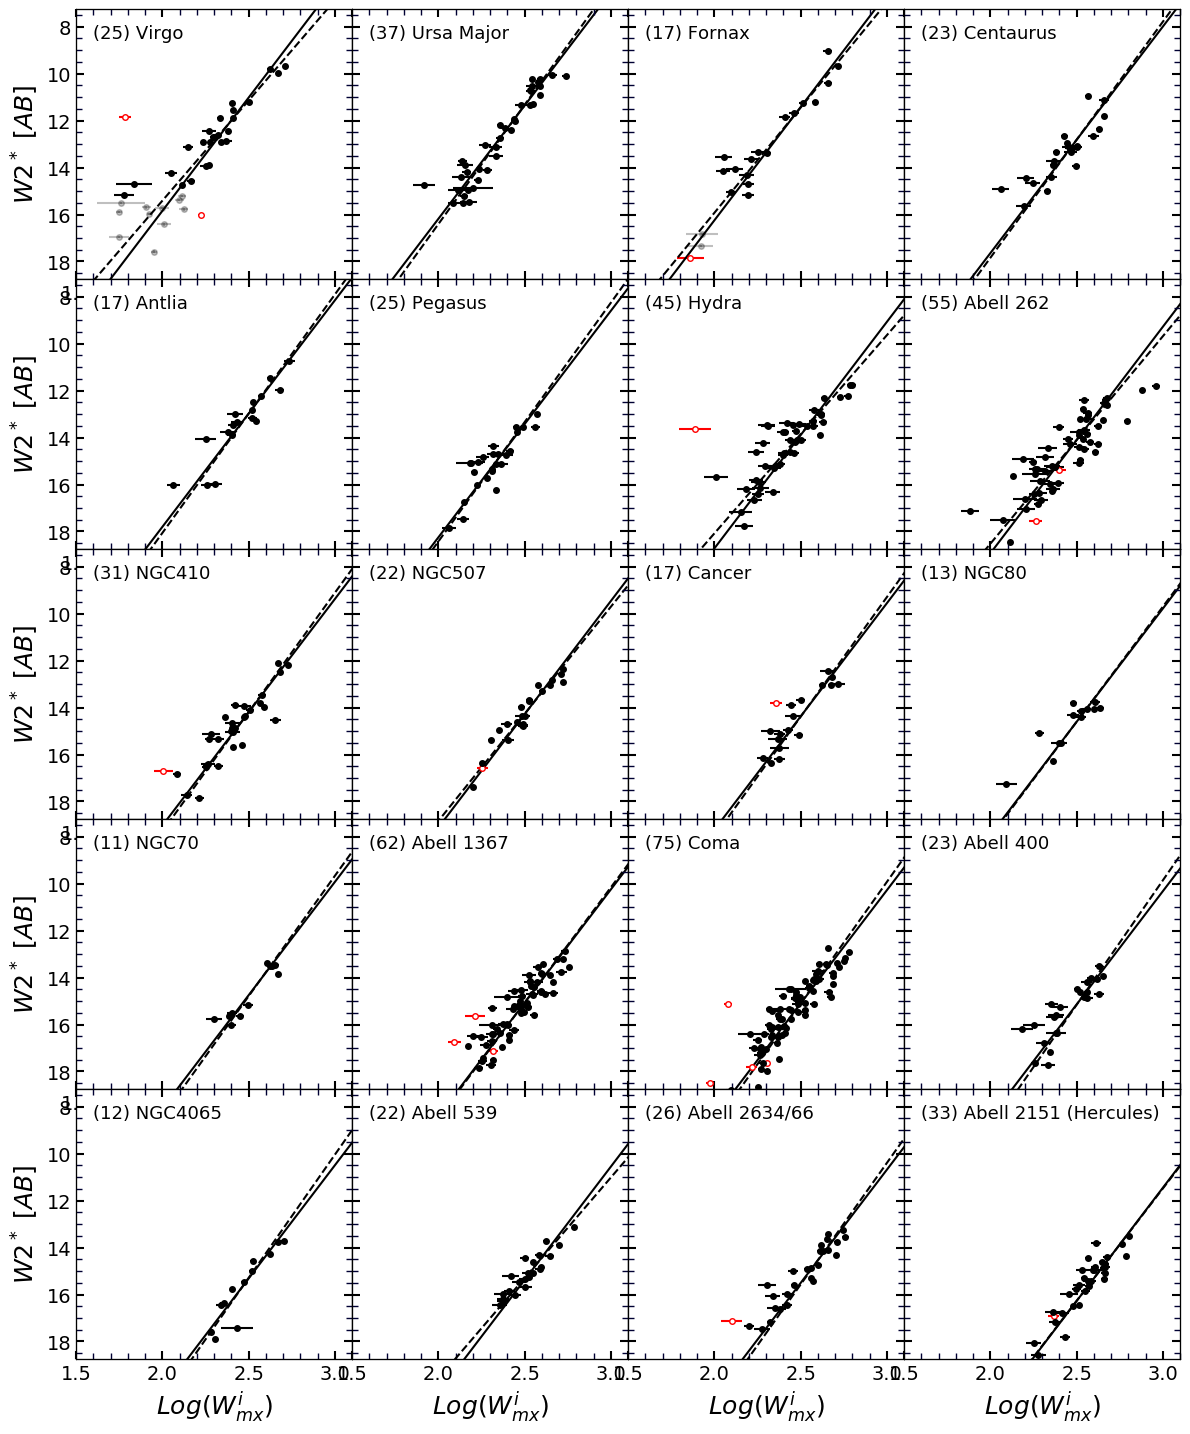

In [9]:
fig = py.figure(figsize=(12, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 4); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%4==0: 
        ax.set_ylabel(r'$'+band.upper()+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>15: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [10]:
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
#     print Clusters[key]['name'], mags[jj][::-1][1]
    print mags[jj][::-1][1]
    


14.76
15.49
15.05
15.0
16.01
17.47
17.17
17.5
17.72
16.34
16.19
16.26
15.75
17.72
18.66
17.65
17.6
16.29
17.32
18.06
